Player sheet target: Tolu Arokodare
Few/no cached values found — using fallback read from player sheet.


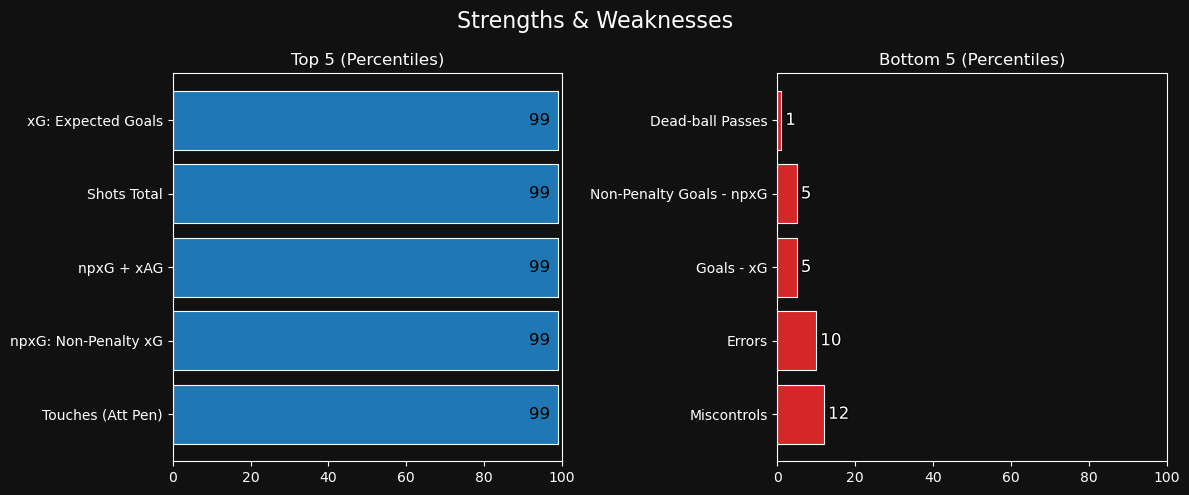

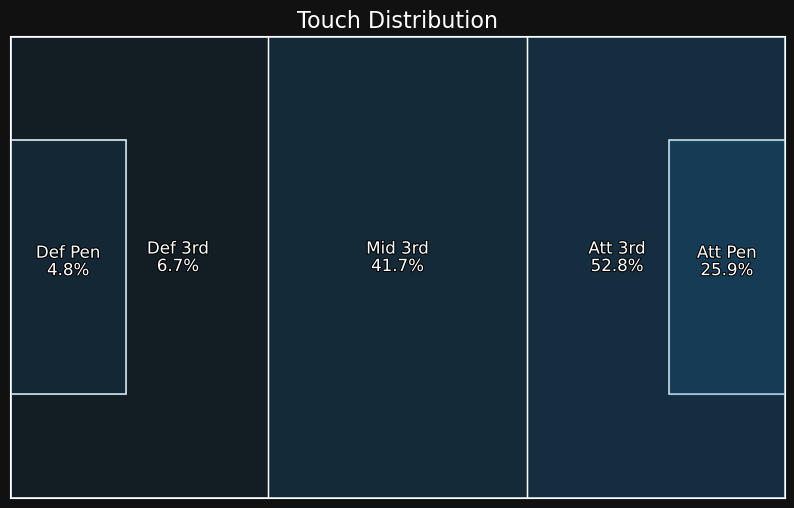

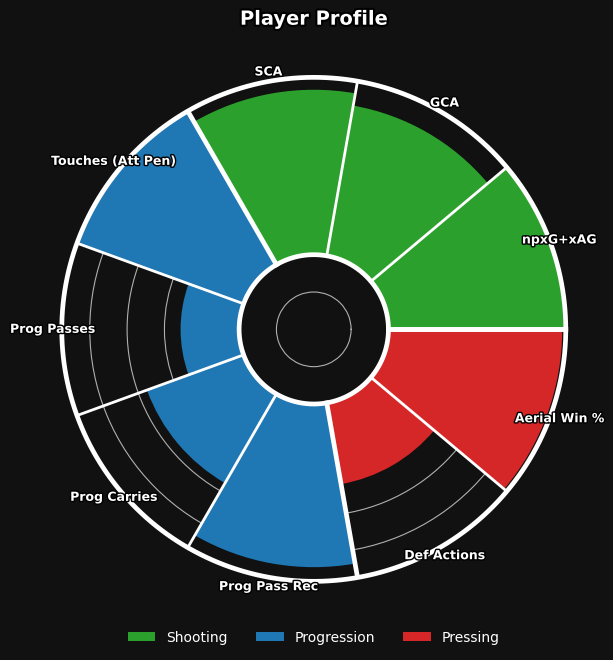

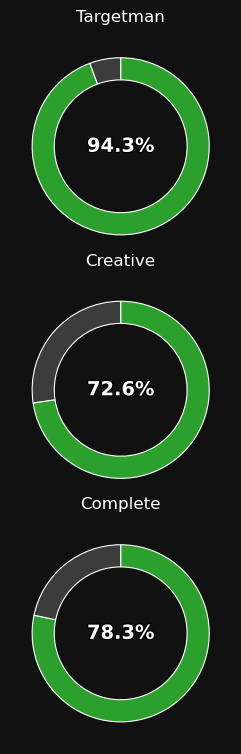

In [7]:
WORKBOOK   = "Tolu-Arokodare.xlsx"  #change file for new dashboard
SHOW_FIGS  = True

import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from openpyxl import load_workbook
from pathlib import Path
import unicodedata, re

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

TILE_BG   = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

DEF_COLOR    = "#d62728" 
PROG_COLOR   = "#1f77b4"  
AERIAL_COLOR = "#2ca02c"  
PASS_COLOR   = "#2ca02c"

TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 10
VALUE_FONTSIZE = 12

mpl.rcParams.update({
    "figure.facecolor": FIG_BG,
    "axes.facecolor": AX_BG,
    "savefig.facecolor": FIG_BG,
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
})

def stroke_txt(_txt="x", lw=1.5):
    return [path_effects.Stroke(linewidth=lw, foreground="black"), path_effects.Normal()]

def clean_axis(ax):
    for side in ("top","right"):
        ax.spines[side].set_visible(False)
    ax.grid(False)

def seed_sheet1_indirect_formulas(workbook_path, player_sheet_hint=None):
    wb = load_workbook(workbook_path)
    sheets = wb.sheetnames
    if player_sheet_hint is None:
        if "Sheet 1" in sheets and len(sheets) > 1:
            for s in sheets:
                if s != "Sheet 1":
                    player_sheet_hint = s
                    break
        else:
            player_sheet_hint = sheets[0]
    wb.save(workbook_path)

    raw = pd.read_excel(workbook_path, sheet_name=player_sheet_hint, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    metric_to_row = {}
    for i, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if m and m.lower() != "nan":
            metric_to_row[m] = i + 1

    from openpyxl import load_workbook as lw
    wb2 = lw(workbook_path)
    if "Sheet 1" not in wb2.sheetnames:
        ws = wb2.create_sheet("Sheet 1", 0)
    else:
        ws = wb2["Sheet 1"]
        for row in ws["A1:Z2000"]:
            for cell in row:
                cell.value = None

    ws["A1"].value = "Player Sheet Name"
    ws["A2"].value = player_sheet_hint
    ws["A4"].value = "Stat"; ws["B4"].value = "Per90"; ws["C4"].value = "Percentile"

    sheet1_fields = [
        "Goals","Assists","Non-Penalty Goals","Penalty Kicks Made",
        "xG: Expected Goals","npxG: Non-Penalty xG","xAG: Exp. Assisted Goals","npxG + xAG",
        "Shots Total","Shots on target","Shot-creating Actions","Goal-creating Actions",
        "Progressive Carries","Carries","Take-Ons Attempted","Successful Take-Ons",
        "Progressive Passes","Passes Completed","Passes Attempted","Pass Completion %",
        "Passes Completed (Short)","Passes Attempted (Short)","Pass Completion % (Short)",
        "Passes Completed (Medium)","Passes Attempted (Medium)","Pass Completion % (Medium)",
        "Passes Completed (Long)","Passes Attempted (Long)","Pass Completion % (Long)",
        "Tackles","Tackles Won","Interceptions","Blocks","Clearances","Errors",
        "Aerials Won","Aerials Lost","% of Aerials Won",
        "Touches","Touches (Def Pen)","Touches (Def 3rd)","Touches (Mid 3rd)",
        "Touches (Att 3rd)","Touches (Att Pen)","Touches (Live-Ball)",
        "Progressive Passing Distance","Total Passing Distance","Passes Received",
        "Progressive Passes Received"
    ]

    r = 5
    for field in sheet1_fields:
        ws[f"A{r}"].value = field
        rn = metric_to_row.get(field)
        if rn is not None:
            per90_formula = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!B{row}"), "")'''.format(row=rn)
            pct_formula   = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!C{row}"), "")'''.format(row=rn)
            ws[f"B{r}"].value = per90_formula
            ws[f"C{r}"].value = pct_formula
        r += 1

    wb2.save(workbook_path)
    print(f"Sheet 1 seeded with INDIRECT formulas; player target = {player_sheet_hint}")

#load
wb = load_workbook(WORKBOOK, data_only=True)
ws = wb["Sheet 1"] if "Sheet 1" in wb.sheetnames else None
if ws is None:
    raise RuntimeError("Sheet 1 not found. Run seed_sheet1_indirect_formulas(WORKBOOK) once.")

PLAYER_SHEET = ws["A2"].value if ws["A2"].value else None
if PLAYER_SHEET is None:
    for s in wb.sheetnames:
        if s != "Sheet 1":
            PLAYER_SHEET = s
            break
print("Player sheet target:", PLAYER_SHEET)

df = pd.read_excel(WORKBOOK, sheet_name="Sheet 1").rename(columns=lambda c: str(c).strip())
per90 = dict(zip(df.get("Stat",[]), df.get("Per90",[])))
pct   = dict(zip(df.get("Stat",[]), df.get("Percentile",[])))

if len([v for v in pct.values() if pd.notna(v)]) < 10:
    print("Few/no cached values found — using fallback read from player sheet.")
    raw = pd.read_excel(WORKBOOK, sheet_name=PLAYER_SHEET, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    per90 = {}; pct = {}
    for _, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if not m or m.lower() == "nan": 
            continue
        try: per90[m] = float(r["Per90"])
        except: pass
        try: pct[m] = float(r["Percentile"])
        except: pass

player_name = PLAYER_SHEET

def g_num(d, name, default=np.nan):
    v = d.get(name, default)
    try:
        return float(v)
    except:
        return default

#helpers
def _norm(s):
    if s is None: return ""
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("—","-").replace("–","-").replace("−","-")
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", "", s)

pct_norm_map = {}
for k, v in pct.items():
    nk = _norm(k)
    if nk not in pct_norm_map or pd.isna(pct_norm_map[nk][1]):
        pct_norm_map[nk] = (k, v)

def get_pct_exact(name):
    """Percentile 0..1 for an exact (normalized) key, else 0"""
    if not name:
        return 0.0
    nk = _norm(name)
    if nk in pct_norm_map and pd.notna(pct_norm_map[nk][1]):
        try:
            return np.clip(float(pct_norm_map[nk][1]) / 100.0, 0, 1)
        except:
            return 0.0
    return 0.0

def get_pct_first(candidates):
    """First available percentile (0..1) from a list of possible names."""
    for c in candidates:
        v = get_pct_exact(c)
        if v > 0:
            return v
    return 0.0

def get_sca_pct():
    """Shot-Creating Actions percentile (0..1), fallback to mean of SCA components if present."""
    v = get_pct_first(["Shot-creating Actions", "Shot Creating Actions", "SCA"])
    if v > 0:
        return v
    comps = []
    for k, v in pct.items():
        if pd.isna(v): 
            continue
        ks = str(k)
        if ks.startswith("SCA (") or ks.startswith("Shot-creating Actions (") or ks.startswith("Shot Creating Actions ("):
            try:
                comps.append(float(v))
            except:
                pass
    if comps:
        return np.clip(float(np.mean(comps)) / 100.0, 0, 1)
    return 0.0

#Strengths & weaknesses
clean_rows = [(k, v) for k, v in pct.items() if pd.notna(v)]
clean = pd.DataFrame(clean_rows, columns=["Stat","Percentile"])
if not clean.empty:
    top5 = clean.sort_values("Percentile", ascending=False).head(5)
    bot5 = clean.sort_values("Percentile", ascending=True).head(5)

    fig = plt.figure(figsize=(12,5)); fig.patch.set_facecolor(FIG_BG)
    plt.suptitle(f"Strengths & Weaknesses", fontsize=16, y=0.98)

    # Top 5
    ax1 = fig.add_subplot(1,2,1); ax1.set_facecolor(AX_BG)
    ax1.barh(top5["Stat"], top5["Percentile"], color=PROG_COLOR, edgecolor="white", linewidth=0.8)
    ax1.set_xlim(0,100); ax1.invert_yaxis(); ax1.set_title("Top 5 (Percentiles)")
    for y, v in enumerate(top5["Percentile"].astype(float).values):
        if np.isnan(v): 
            continue
        txtcol, ha, xoff = ("black","right",-2) if v >= 8 else ("white","left",1)
        ax1.text(v + xoff, y, f"{v:.0f}", va="center", ha=ha, fontsize=12,
                 color=txtcol, path_effects=([] if txtcol=="black" else stroke_txt()))

    ax2 = fig.add_subplot(1,2,2); ax2.set_facecolor(AX_BG)
    ax2.barh(bot5["Stat"], bot5["Percentile"], color=DEF_COLOR, edgecolor="white", linewidth=0.8)
    ax2.set_xlim(0,100); ax2.invert_yaxis(); ax2.set_title("Bottom 5 (Percentiles)")
    for y, v in enumerate(bot5["Percentile"]):
        ax2.text(min(99, v+1), y, f"{v:.0f}", va="center", fontsize=12, path_effects=stroke_txt())

    plt.tight_layout()
    if SHOW_FIGS: plt.show()

#pitch touch distribution
tot = g_num(per90, "Touches", np.nan)
zones = [("Def Pen", g_num(per90, "Touches (Def Pen)")),
         ("Def 3rd", g_num(per90, "Touches (Def 3rd)")),
         ("Mid 3rd", g_num(per90, "Touches (Mid 3rd)")),
         ("Att 3rd", g_num(per90, "Touches (Att 3rd)")),
         ("Att Pen", g_num(per90, "Touches (Att Pen)"))]
shares = [ (0.0 if (pd.isna(tot) or tot==0 or pd.isna(v)) else v/tot) for _, v in zones ]

fig = plt.figure(figsize=(10,6)); ax = fig.add_subplot(111); ax.set_facecolor(AX_BG)
ax.add_patch(Rectangle((0,0), 120, 80, fill=False, ec="white", lw=2.0))
ax.plot([40,40],[0,80], color="white", lw=1.0); ax.plot([80,80],[0,80], color="white", lw=1.0)
ax.add_patch(Rectangle((0,18), 18, 44, fill=False, ec="white", lw=1.2))
ax.add_patch(Rectangle((102,18), 18, 44, fill=False, ec="white", lw=1.2))

fills = [ ((0,18,18,44), shares[0], "Def Pen"),
          ((0,0,40,80), shares[1], "Def 3rd"),
          ((40,0,40,80), shares[2], "Mid 3rd"),
          ((80,0,40,80), shares[3], "Att 3rd"),
          ((102,18,18,44), shares[4], "Att Pen") ]
for (x, y, w, h), s, lab in fills:
    alpha = 0.10 + 0.35 * (s)
    ax.add_patch(Rectangle((x, y), w, h, fc=PROG_COLOR, ec="white", lw=1.0, alpha=alpha))
    frac_x = 0.50
    if lab == "Def 3rd": frac_x = 0.65
    elif lab == "Att 3rd": frac_x = 0.35
    cx = x + w * frac_x
    cy = y + h * 0.52
    ax.text(cx, cy, f"{lab}\n{s*100:.1f}%", ha="center", va="center",
            fontsize=12, path_effects=stroke_txt())

ax.set_xlim(0,120); ax.set_ylim(0,80); ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"Touch Distribution", fontsize=16)
if SHOW_FIGS: plt.show()

#Big donut
VIS_MIN = 0.07
FLOOR_ZEROES = False

shoot_labels = ["npxG+xAG", "GCA", "SCA"]
def shoot_vals():
    v1 = get_pct_first(["npxG + xAG","npxG+xAG","npxG and xAG","npxG: Non-Penalty xG + xAG"])
    v2 = get_pct_first(["Goal-creating Actions","GCA"])
    v3 = get_sca_pct()
    return [v1, v2, v3]

prog_labels = ["Touches (Att Pen)", "Prog Passes", "Prog Carries", "Prog Pass Rec"]
def prog_vals():
    v1 = get_pct_first(["Touches (Att Pen)","Touches (Att Pen.)","Touches (Att Penalty)"])
    v2 = get_pct_first(["Progressive Passes","Prog Passes"])
    v3 = get_pct_first(["Progressive Carries","Prog Carries"])
    v4 = get_pct_first([
        "Progressive Passes Received","Prog Passes Received",
        "Progressive Passes Rec","Prog Pass Rec","Passes Received"
    ])
    return [v1, v2, v3, v4]

press_labels = ["Def Actions", "Aerial Win %"]
def press_vals():
    parts = []
    for key in ["Tackles","Interceptions","Blocks","Clearances"]:
        parts.append(get_pct_first([key]))
    da = np.nanmean([p if p>0 else np.nan for p in parts])
    da = float(da) if not np.isnan(da) else 0.0
    aw = get_pct_first(["% of Aerials Won","Aerials Won %","Aerial Win %"])
    return [da, aw]

labels_vals = []
labels_vals += list(zip(shoot_labels, shoot_vals()))
labels_vals += list(zip(prog_labels,  prog_vals()))
labels_vals += list(zip(press_labels, press_vals()))

labels = [lab for lab, _ in labels_vals]
vals   = np.array([float(v) for _, v in labels_vals])
if FLOOR_ZEROES:
    vals_plot = np.maximum(vals, VIS_MIN)
else:
    vals_plot = np.where(vals > 0, np.maximum(vals, VIS_MIN), 0.0)

n = len(labels)
shoot_end = len(shoot_labels)   
prog_end  = shoot_end + len(prog_labels)
press_end = n

angles = np.linspace(0, 2*np.pi, n, endpoint=False)
width  = 2*np.pi / n
theta_circle = np.linspace(0, 2*np.pi, 720)

inner_radius  = 0.35
outer_radius  = inner_radius + 1.0
inner_overlay = inner_radius + 0.05
scale = outer_radius - inner_overlay

def color_by_index(i):
    if i < shoot_end:
        return AERIAL_COLOR   
    elif i < prog_end:
        return PROG_COLOR       
    else:
        return DEF_COLOR      

wedge_colors = [color_by_index(i) for i in range(n)]

fig = plt.figure(figsize=(7.2,7.2)); fig.patch.set_facecolor(FIG_BG)
ax  = plt.subplot(111, polar=True); ax.set_facecolor(AX_BG); ax.set_ylim(0, outer_radius)

ax.bar(angles, vals_plot * scale, width=width, bottom=inner_overlay, align="edge",
       color=wedge_colors, zorder=2)

for ang in angles:
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3)

for b in (0, shoot_end, prog_end, press_end):
    ang = angles[b % n]
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4)

ax.plot(theta_circle, np.full_like(theta_circle, outer_radius), color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False)
ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay), color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False)

for ang, lab in zip(angles + width/2, labels):
    t = ax.text(ang, inner_radius + 1.05, lab, ha="center", va="center",
                fontsize=9, fontweight="bold", color="white", zorder=6)
    t.set_path_effects([path_effects.Stroke(linewidth=2, foreground="black"), path_effects.Normal()])

title = ax.set_title(f"Player Profile", va="bottom", y=1.08, fontsize=14, fontweight="bold", color="white")
title.set_path_effects([path_effects.Stroke(linewidth=3, foreground="black"), path_effects.Normal()])

legend_handles = [
    Patch(facecolor=AERIAL_COLOR, label="Shooting"),
    Patch(facecolor=PROG_COLOR,   label="Progression"),
    Patch(facecolor=DEF_COLOR,    label="Pressing"),
]
leg = ax.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5, -0.15),
                ncol=3, frameon=True)
plt.setp(leg.get_texts(), color="white")
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])
plt.subplots_adjust(bottom=0.18)

if SHOW_FIGS: plt.show()
else: plt.close(fig)

#player type
TM_keys = [
    "% of Aerials Won", "Aerials Won %", "Aerial Win %",
    "Touches (Att Pen)", "Touches (Att Pen.)", "Touches (Att Penalty)",
    "Progressive Passes Received","Prog Passes Received","Passes Received"
]

CR_keys = [
    "xAG: Exp. Assisted Goals","Expected Assisted Goals","xAG",
    "Shot-creating Actions","Shot Creating Actions","SCA",
    "Goal-creating Actions","GCA",
    "Progressive Passes","Prog Passes"
]

CP_components = (
    shoot_labels + prog_labels + press_labels
)

def mean_pct(keys):
    vals = []
    for k in keys:
        if k in CP_components:
            pass
    for k in keys:
        if k == "SCA":
            v = get_sca_pct()
        else:
            v = get_pct_first([k])
        if v > 0:
            vals.append(v)
    if not vals:
        return 0.0
    return float(np.mean(vals))

donut_val_map = {}
for lab, val in zip(shoot_labels, shoot_vals()):
    donut_val_map[lab] = val
for lab, val in zip(prog_labels, prog_vals()):
    donut_val_map[lab] = val
for lab, val in zip(press_labels, press_vals()):
    donut_val_map[lab] = val

def mean_pct_mixed(keys):
    """Keys may include raw metric names or donut labels."""
    vals = []
    for k in keys:
        if k in donut_val_map:
            v = donut_val_map[k]
        elif k == "SCA":
            v = get_sca_pct()
        else:
            v = get_pct_first([k])
        if v > 0:
            vals.append(v)
    if not vals:
        return 0.0
    return float(np.mean(vals))

targetman_score = 100.0 * mean_pct_mixed(TM_keys)
creative_score  = 100.0 * mean_pct_mixed(CR_keys)
complete_score  = 100.0 * mean_pct_mixed(CP_components)  # broad average

pt_labels = ["Targetman", "Creative", "Complete"]
pt_vals   = [targetman_score, creative_score, complete_score]
pt_vals   = [np.clip(v, 0, 100) for v in pt_vals]

GREEN = PASS_COLOR
GREY  = "#3c3c3c"

fig, axs = plt.subplots(3, 1, figsize=(4.6, 9.2),
                        subplot_kw=dict(aspect="equal"),
                        gridspec_kw={"hspace": 0.10})
fig.patch.set_facecolor(FIG_BG)

for ax, lab, val in zip(axs, pt_labels, pt_vals):
    ax.set_facecolor(AX_BG)
    sizes = [float(val), max(0.0, 100.0 - float(val))]
    ax.pie(
        sizes, startangle=90, counterclock=False,
        colors=[GREEN, GREY],
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=0.8),
    )
    ax.text(0, 0, f"{val:.1f}%", ha="center", va="center",
            fontsize=14, fontweight="bold", color="white", path_effects=stroke_txt())
    ax.set_title(lab, fontsize=12, color="white", pad=10)

if SHOW_FIGS: plt.show()
